In [1]:
import glob
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import PIL
import seaborn as sns
import shutil
import ultralytics
import wandb
import yaml

from collections import defaultdict
from tqdm.notebook import tqdm
from ultralytics import YOLO
from wandb.integration.ultralytics import add_wandb_callback

import params

/Users/matthewzak/miniconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/matthewzak/miniconda3/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /Users/matthewzak/miniconda3/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <1FAC2D7E-618C-3A6D-BC20-D8F31AE257E9> /Users/matthewzak/miniconda3/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
wandb: WARNING This integration is tested and supported for ultralytics v8.0.238 and below.
wandb: WARNING             Please report any issues to https://github.com/wandb/w

In [12]:
with open("data/dataset/train_data.json", "r") as f:
    train_data = json.load(f)

In [13]:
categories = sorted(train_data["categories"], key=lambda cat: cat["id"])
CLASSES = [cat["name"] for cat in categories]
NUM_CLASSES_TO_TRAIN = len(CLASSES)

In [12]:
BASE_MODEL = 'yolov8x' # yolov8n, yolov8s, yolov8m, yolov8l, yolov8x
EPOCHS = 20
BATCH_SIZE = 16
BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
OPTIMIZER = 'auto' # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
LR = 1e-3
LR_FACTOR = 0.01
WEIGHT_DECAY = 5e-4

In [3]:
DATA_PATH = "data/yolo_dataset"
TRAIN_DATA_PATH = os.path.join(DATA_PATH, "train")
VAL_DATA_PATH = os.path.join(DATA_PATH, "val")
if not os.path.isdir(DATA_PATH):
    os.mkdir(DATA_PATH)
    os.mkdir(TRAIN_DATA_PATH)
    os.mkdir(os.path.join(TRAIN_DATA_PATH, "images"))
    os.mkdir(os.path.join(TRAIN_DATA_PATH, "labels"))
    os.mkdir(VAL_DATA_PATH)
    os.mkdir(os.path.join(VAL_DATA_PATH, "images"))
    os.mkdir(os.path.join(VAL_DATA_PATH, "labels"))

In [5]:
train_data.keys()

dict_keys(['info', 'images', 'licenses', 'annotations', 'categories'])

In [6]:
train_data["annotations"][0]

{'id': 2,
 'image_id': 2,
 'category_id': 0,
 'segmentation': [],
 'area': 8775.0,
 'bbox': [346.0, 191.0, 135.0, 65.0],
 'iscrowd': 0}

In [41]:
# create labeled files.
# source path (images)
# destination. Save under the same file name
def create_yolo_data(image_data, annotations, source_path, destination_path):
    """Copy images from their source to the new destination. Create corresponding label files"""

    image_name = image_data["file_name"]
    shutil.copy(
        os.path.join(source_path, image_name),
        os.path.join(destination_path, "images", image_name)
    )
    width, height = PIL.Image.open(os.path.join(source_path, image_name)).size
    label_content = []
    for anno in annotations:
        category = anno["category_id"]
        x, y, w, h = anno["bbox"]
        x_centre = x + w // 2
        y_centre = y + h // 2
        if x_centre / width > 1 or y_centre / height > 1:
            continue
        label_content.append(
            f"{category} {x_centre / width} {y_centre / height} {w / width} {h / height}"
        )
    label_content = "\n".join(label_content)
    label_name = image_name.split(".")[0] + ".txt"
    with open(os.path.join(destination_path, "labels", label_name), "w") as f:
        f.write(label_content)

In [42]:
for image_data in tqdm(train_data["images"]):
    curr_annos = [anno for anno in train_data["annotations"] if anno["image_id"] == image_data["id"]]
    curr_annos = [anno for anno in curr_annos if anno["bbox"][2] > 0 and anno["bbox"][3] > 0]
    if len(curr_annos) > 0:
        create_yolo_data(image_data, curr_annos, "data/dataset/images/", "data/yolo_dataset/train/")

  0%|          | 0/4760 [00:00<?, ?it/s]

In [34]:
with open("data/val_data.json", "r") as f:
    val_data = json.load(f)

for image_data in tqdm(val_data["images"]):
    curr_annos = [anno for anno in val_data["annotations"] if anno["image_id"] == image_data["id"]]
    curr_annos = [anno for anno in curr_annos if anno["bbox"][2] > 0 and anno["bbox"][3] > 0]
    if len(curr_annos) > 0:
        create_yolo_data(image_data, curr_annos, "data/dataset/images/", "data/yolo_dataset/val/")

  0%|          | 0/1190 [00:00<?, ?it/s]

In [15]:
class_idx = {str(i): CLASSES[i] for i in range(NUM_CLASSES_TO_TRAIN)}
class_stat = {}
data_len = {}
class_info = []
for mode in ["train", "val"]:
    class_count = defaultdict(lambda: 0)

    path = os.path.join(DATA_PATH, mode, "labels")

    for file in os.listdir(path):
        if "ipynb_checkpoints" in file:
            continue
        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line.split(" ")[0] for line in lines]):
                class_count[class_idx[cls]] += 1
    class_count = {key: val for key, val in class_count.items() if val > 0}
    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

    class_info.append({"Mode": mode, **class_count, "Volume": data_len[mode]})

dataset_stats_df = pd.DataFrame(class_info)
dataset_stats_df

,Mode,Strongylocentrotus fragilis,Apostichopus leukothele,Pannychia,Tritonia tetraquetra,Mediaster,Liponema brevicorne,Caridea,Anoplopoma fimbria,Rathbunaster californicus,...,Anguilliformes,Icelinus,Lepidisis,Careproctus,Polychaeta,Ceramaster,Stylatula,Careproctus melanurus,Farrea,Volume
0,train,2126,107,85,4,46,110,21,45,552,...,1.0,1,1.0,1.0,2.0,1.0,1.0,1,1.0,4760
1,val,517,29,21,5,15,22,4,8,144,...,NaN,1,NaN,NaN,NaN,NaN,NaN,1,NaN,1190


In [25]:
# Create a yaml file
dict_file = {
    "path": os.path.join("..", DATA_PATH),
    "train": os.path.join("..", "train", "images"),
    "val": os.path.join("..", "val", "images"),
    "nc": NUM_CLASSES_TO_TRAIN,
    "names": CLASSES
}

with open(os.path.join(DATA_PATH, "data.yaml"), "w") as f:
    yaml.dump(dict_file, f)

In [4]:
run = wandb.init(project=params.WANDB_PROJECT, entity=params.ENTITY, job_type="save_yolov8_data")
processed_data_at = wandb.Artifact(params.PROCESSED_YOLO_DATA_AT, type="dataset")
processed_data_at.add_dir(DATA_PATH)
run.log_artifact(processed_data_at)
run.finish()

wandb: Adding directory to artifact (./data/yolo_dataset)... Done. 25.4s


In [19]:
# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot vertical bar plots for each mode in subplots
for i, mode in enumerate(["train", "val"]):
    sns.barplot(
        data=dataset_stats_df[dataset_stats_df['Mode'] == mode].drop(columns='Mode'),
        orient='v',
        ax=axes[i],
        palette='Set2'
    )
    
    axes[i].set_title(f'{mode.capitalize()} Class Statistics')
    axes[i].set_xlabel('Classes')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90) 

    # Add annotations on top of each bar
    for p in axes[i].patches:
        axes[i].annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                         textcoords='offset points')

plt.tight_layout()
plt.show()

<Figure size 1500x500 with 2 Axes>

In [61]:
image_sizes = defaultdict(lambda: 0)
for mode in ['train', 'val']:
    img_size = 0
    for file in glob.glob(os.path.join(DATA_PATH, mode, 'images', '*')):
        image = PIL.Image.open(file)
        image_sizes[image.size] += 1

In [63]:
image_sizes

defaultdict(<function __main__.<lambda>()>,
            {(1920, 1080): 2928,
             (714, 368): 992,
             (716, 370): 159,
             (720, 366): 542,
             (715, 368): 116,
             (720, 486): 48,
             (720, 368): 587,
             (712, 368): 22,
             (1920, 1079): 59,
             (714, 370): 42,
             (720, 369): 140,
             (713, 368): 75,
             (715, 370): 71,
             (720, 367): 68,
             (1920, 977): 1,
             (713, 424): 10,
             (713, 460): 1,
             (720, 476): 2,
             (716, 368): 23,
             (715, 369): 1,
             (716, 486): 5,
             (712, 425): 2,
             (715, 486): 7,
             (714, 486): 8,
             (720, 470): 2,
             (713, 425): 7,
             (720, 426): 3,
             (714, 369): 1,
             (720, 370): 5,
             (713, 369): 1,
             (1919, 1080): 1,
             (1793, 1080): 1,
             (720, 458): 1,

In [20]:
print('Model: ', BASE_MODEL_WEIGHTS)
print('Epochs: ', EPOCHS)
print('Batch: ', BATCH_SIZE)

Model:  yolov8x.pt
Epochs:  20
Batch:  16


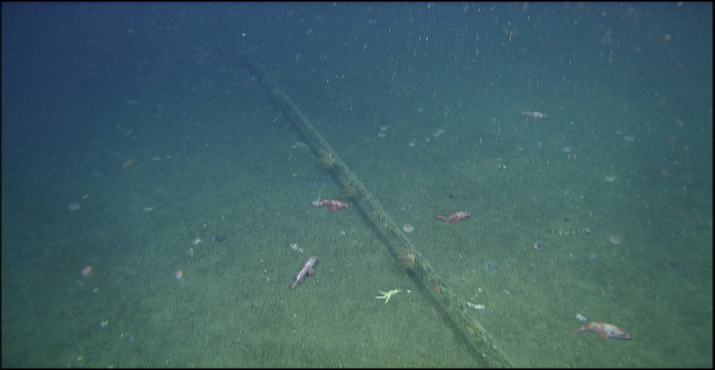

In [45]:
PIL.Image.open("data/yolo_dataset/train/images/95065656-53c4-4474-b7ec-a8104b0f62b2.png")

wandb: Downloading large artifact fanthom_data_processed_yolo:latest, 9474.87MB. 11905 files... 
wandb:   11905 of 11905 files downloaded.  
Done. 0:0:27.0


In [10]:
artifact_dir

'/Users/matthewzak/projects/fanthomnet/artifacts/fanthom_data_processed_yolo:v0'

In [17]:
model = YOLO(BASE_MODEL_WEIGHTS)
for k, v in model.model.model.named_parameters():
    if not k.startswith("22"):
        v.requires_grad = False
add_wandb_callback(model, enable_model_checkpointing=True)
model.train(
    data = os.path.join(DATA_PATH, 'data.yaml'),
    task = 'detect',
    imgsz = (714, 368),

    epochs = EPOCHS,
    batch = 8, #BATCH_SIZE,
    optimizer = OPTIMIZER,
    lr0 = LR,
    lrf = LR_FACTOR,
    weight_decay = WEIGHT_DECAY,
    patience = 10,

    name = f'{BASE_MODEL}_init_train',
    seed = 42,
    
    save_period = 1,
    val = True,
    amp = True,    
    exist_ok = True,
    resume = False,
    device = "mps",
    verbose = False,
)
wandb.finish()

New https://pypi.org/project/ultralytics/8.1.18 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.17 🚀 Python-3.11.6 torch-2.3.0.dev20240127 MPS (Apple M1 Pro)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/Users/matthewzak/projects/fanthomnet/artifacts/fanthom_data_processed_yolo:v0/data.yaml, epochs=20, time=None, patience=10, batch=8, imgsz=(714, 368), save=True, save_period=1, cache=False, device=mps, workers=8, project=None, name=yolov8x_init_train, exist_ok=True, pretrained=True, optimizer=auto, verbose=False, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_n

train: Scanning /Users/matthewzak/projects/fanthomnet/data/yolo_dataset/train/labels.cache... 4759 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4759/4759 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /Users/matthewzak/projects/fanthomnet/data/yolo_dataset/val/labels.cache... 1190 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1190/1190 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov8x_init_train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=7.3e-05, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 736 train, 736 val
Using 0 dataloader workers
Logging results to runs/detect/yolov8x_init_train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/595 [03:04<?, ?it/s]


KeyboardInterrupt: 